# Abstract Condesnor
The purpose of this notebook is to demonstrate the steps taken to create an NLP model for reading Abstracts and condensing them into a digestable format.


Inspiriation was taken from the following paper and an attempt to replicate such model will be used: 
> https://arxiv.org/abs/1710.06071


Further information regarding how the model was built can be found here: 
> https://arxiv.org/pdf/1612.05251.pdf.

In [4]:
# Confirm GPU is being used
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-01f10189-8ddd-ac8e-6322-39335cd098be)


## Collecting and processing data

A dataset must be used to train the model. The authors of the paper have released their dataset on github which will be used to train the model. From my understanding, the authors found papers that had already identified the background, objective, methods, results, and conclusions. A lot of work went into collecting thousands of these papers and I felt it was more efficient to use a dataset that must have taken many hours to collect and compile than creating my own.

In [5]:
# Downloading dataset from the paper replicated above: https://github.com/Franck-Dernoncourt/pubmed-rct
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [7]:
# Create a function to read the lines of our data
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
# Create function to parse the abstract text files
def preprocess_text(filename):
    input_lines = get_lines(filename) # Retrieve the lines of text
    abstract_lines = ""
    abstract_samples = []

# Loop through each line
    for line in input_lines:
        if line.startswith("###"): # Check if line is an ID line
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # Split abstract into separate lines
            
            # Loop through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t") # Split label from text
                line_data["target"] = target_text_split[0] # Get label
                line_data["text"] = target_text_split[1].lower() # Get sentence in lower case
                line_data["line_number"] = abstract_line_number # Get line number
                line_data["total_lines"] = len(abstract_line_split) - 1 # Count total lines in abstract by subtracting one since we start at 0
                abstract_samples.append(line_data) # Add line data to abstract samples list
        else: # If line is not an ID line or empty line, add text to abstract lines
            abstract_lines += line
            
    return abstract_samples

In [10]:
# Check metrics on function
import timeit
start_time = timeit.default_timer()
train_samples = preprocess_text(data_dir + "train.txt")
dev_samples = preprocess_text(data_dir + "dev.txt")
test_samples = preprocess_text(data_dir + "test.txt")
elapsed = timeit.default_timer() - start_time
len(train_samples), len(dev_samples), len(test_samples), elapsed

(180040, 30212, 30135, 0.372483299986925)

In [11]:
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Moving towards visualizing data

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training set
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

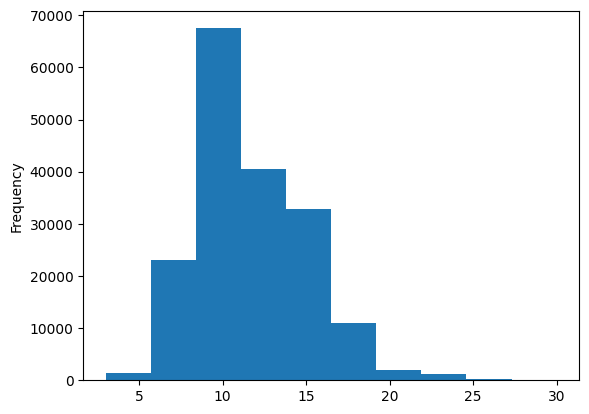

In [14]:
train_df.total_lines.plot.hist();

In [15]:
# Converting abstract text lines into lists
train_sentences = train_df["text"].tolist()
dev_sentences = dev_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(dev_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# Check lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
# One hot encoding labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # Instantiate one hot encoder into an array
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.fit_transform(dev_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check results of one hot encoding
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
# Get the class names of the labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
dev_labels_encoded = label_encoder.fit_transform(dev_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check results of label encoding
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Retrieve class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of models

### Naive Bayes Model

Model 0 will be a TF-IDF Multinomial Naive Bayes which has been recommended by the scikit-learn ML map.
> https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [21]:
# Evaluate the baseline model
model_0.score(X=dev_sentences,
              y=dev_labels_encoded)

0.7218323844829869

73.1% accuracy

In [22]:
# Make predictions
baseline_preds = model_0.predict(dev_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Making a function to calculate results
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100 # Calculate accuracy score in percentage
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted") # Calculate precision, recall and f1 score using "weighted" average
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
# Calculating baseline results
baseline_results = calculate_results(y_true=dev_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing data for deep learning models

In order to use deep learning models on our data, it must first be tokenized (words turned into numbers) and then we must create embedding layers (which captures the relationship between those numbers).

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

First, we must determine the length of the sentences. When the model goes through the sentences, it will perform best when they are all the same length which is important for creating batches of the same size tensors. We can extend the shorter sentences via padding so they end up being the same length

In [26]:
# Checking length of sentence on average
sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_len)
avg_sentence_len

26.338269273494777

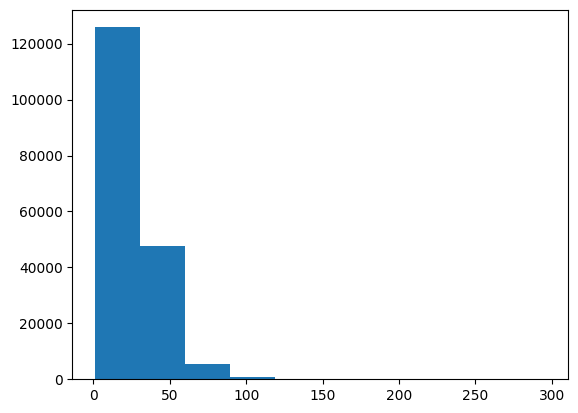

In [27]:
# Checking distribution of sentence length
import matplotlib.pyplot as plt
plt.hist(sentence_len, bins=10);

Vast majority of sentences are between 0 and 50 tokens.

In [28]:
# Determining what sentence length covers 95% of the training set
output_token_len = int(np.percentile(sentence_len, 95))
output_token_len

55

In [29]:
# Setting max token length (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [30]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_token_len)

In [31]:
# Adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Checking text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
antiepileptic treatment is based on guidelines for treatment of overt status epilepticus and is started within @ hours after the diagnosis .

Length of text: 22

Vectorized text:
[[7117   19   20  261   18  979   11   19    4 8013  272 9182    3   20
  1973  219  227   21    2  536    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
# Analyzing training vocabulary
rct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_vocab)}")
print(f"Most common words in vocab: {rct_20k_vocab[:10]}")
print(f"Least common words in vocab: {rct_20k_vocab[-10:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in vocab: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

Now that we have tokenized our data, it is time to create the embedding layer.

In [35]:
# Creating token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab), # Vocab length
                                 output_dim=128,
                                 mask_zero=True, # Using masking to handle variable sequence lengths which saves space
                                 name="token_embedding")

# Show embedding example
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization and before embedding:\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
antiepileptic treatment is based on guidelines for treatment of overt status epilepticus and is started within @ hours after the diagnosis .

Sentence after vectorization and before embedding:
[[7117   19   20  261   18  979   11   19    4 8013  272 9182    3   20
  1973  219  227   21    2  536    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.03395866 -0.00085579 -0.02881077 ... -0.0291775   0.04355917
   -0.04790089]
  [-0.0130036   0.03633913  0.04045949 ...  0.00308404  0.04348408
   -0.00820582]
  [ 0.02950596 -0.01218709 -0.00535663 ...  0.04382345 -0.02009845
   -0.01052199]
  ...
  [-0.03757672  0.03527704  0.03498319 ... -0.04112858  0.01721675
   -0.02849947]
  [-0.03757672  0.03527704  0.03498319 ... -0.04112858  0.01721675
   -0.02849947]
  [-0.03757672  0.03527704  0.03498319 ... 

Now the data must be turned into Tensorflow datasets so it can load our data onto the GPU faster which will decrease training time.

In [36]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset, dev_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [37]:
# Take the TensorFlow datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset, dev_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Conv1D Model

1D convolution layer

In [38]:
inputs = layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1-dimensional strings
text_vectors = text_vectorizer(inputs) # Turn input text into token embeddings
token_embeddings = token_embed(text_vectors) # Create token embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings) # Add first convolutional layer
x = layers.GlobalAveragePooling1D()(x) # Reduce the output of the convolutional layer to a single vector per example
outputs = layers.Dense(num_classes, activation="softmax")(x) # Create the output layer, one neuron per class. Softmax for multiclass
model_1 = tf.keras.Model(inputs, outputs) # Construct the model

# Compile model
model_1.compile(loss="categorical_crossentropy", # Categorical crossentropy since we have more than two classes
                optimizer=tf.keras.optimizers.Adam(), # Using Adam optimizer because it performs well with default learning rate
                metrics=["accuracy"]) # Want to see how accurate the model is (but doesn't account for class imbalance)

In [39]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

When testing the model, it is ideal to test it on a smaller subset of the data before scaling to a larger dataset. We will test the model on 10% of the data.

In [40]:
# Fitting the model
model_1_fit = model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1 * len(train_dataset)), # Use 10% of steps per epoch (since we're using the full dataset, this is ~10% of the batches)
                            epochs=3, # Only train for 3 epochs to begin with. Epoch is one pass through the training data
                            validation_data=dev_dataset, # Model will tell us how it's performing on the dev_dataset during training
                            validation_steps=int(0.1 * len(dev_dataset))) # Use 10% of the dev_dataset for validation

Epoch 1/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9179 - accuracy: 0.6395 - val_loss: 0.6836 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.6564 - accuracy: 0.7586 - val_loss: 0.6312 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 28s 49ms/step - loss: 0.6155 - accuracy: 0.7750 - val_loss: 0.5935 - val_accuracy: 0.7886


In [41]:
# Evaluate on whole dev dataset
model_1.evaluate(dev_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.5954 - accuracy: 0.7885


[0.5953621864318848, 0.7885277271270752]

In [42]:
# Make predictions
model_1_pred_probs = model_1.predict(dev_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.3177271e-01, 1.5646218e-01, 7.3353149e-02, 3.1191394e-01,
        2.6498087e-02],
       [4.4000417e-01, 2.7192435e-01, 1.5583176e-02, 2.6435363e-01,
        8.1346333e-03],
       [1.4473552e-01, 7.0046862e-03, 1.8525829e-03, 8.4636921e-01,
        3.8025097e-05],
       ...,
       [9.5971145e-06, 7.9297269e-04, 7.8132527e-04, 5.9547297e-06,
        9.9841011e-01],
       [4.9055904e-02, 4.7942770e-01, 9.1510020e-02, 6.5368071e-02,
        3.1463826e-01],
       [1.3528812e-01, 7.3296034e-01, 5.2577339e-02, 3.6580294e-02,
        4.2593941e-02]], dtype=float32)

In [43]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [44]:
# Calculate results
model_1_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.85277373229181,
 'precision': 0.7856175823194537,
 'recall': 0.788527737322918,
 'f1': 0.78619075730367}

78.6% accuracy but I think there would but I think it would be best to try different models to increase accuracy.

### Feature extract model with pretrained token embeddings

The paper mentiones using a pretrained Universal Sentence Encoder from TensorFlow Hub so I will try that next.

In [45]:
# Download pretrained TensorFlow Hub Universal Sentence Encoder
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [46]:
# Testing the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
fridericia 's correction was applied to qt recordings ( qtcf ) , and change from baseline ( qtcf ) was calculated .
Sentence after embedding:
[-0.02190101 -0.0303824   0.0327255  -0.02616528 -0.02167959 -0.02191286
  0.01075757 -0.03322763  0.00666392  0.06328618 -0.02502545  0.07896996
 -0.03120594  0.04973472 -0.04619331  0.03942116 -0.01575639  0.0446329
 -0.04867771  0.05582621 -0.04671801  0.02421292 -0.05582324  0.07078356
 -0.05023021  0.06014596  0.02818715  0.00290006  0.02758862  0.04157858]

Length of sentence embedding: 512


In [47]:
# Building the model
inputs = layers.Input(shape=[], dtype=tf.string) # Inputs are 1-dimensional strings
pretrained_embedding = tf_hub_embedding_layer(inputs) # Turn input text into token embeddings
x = layers.Dense(128, activation="relu")(pretrained_embedding) # Add a fully connected layer on top of the embedding
outputs = layers.Dense(num_classes, activation="softmax")(x) # Create the output layer, one neuron per class. Softmax for multiclass
model_2 = tf.keras.Model(inputs, outputs) # Construct the model

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [49]:
# Fit the model
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=dev_dataset,
            validation_steps=int(0.1 * len(dev_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 0.9183 - accuracy: 0.6496 - val_loss: 0.7963 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7677 - accuracy: 0.7038 - val_loss: 0.7542 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7505 - accuracy: 0.7144 - val_loss: 0.7374 - val_accuracy: 0.7164


In [50]:
# Evaluate on whole dev dataset
model_2.evaluate(dev_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.7406 - accuracy: 0.7149


[0.740623950958252, 0.7149477005004883]

In [51]:
# Make predictions
model_2_pred_probs = model_2.predict(dev_dataset)
model_2_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[0.41846964, 0.35086888, 0.00185905, 0.22155808, 0.00724439],
       [0.30912393, 0.52406204, 0.00489887, 0.15946642, 0.00244869],
       [0.22339506, 0.1527133 , 0.01502395, 0.568613  , 0.04025463],
       ...,
       [0.00219161, 0.0065263 , 0.0545045 , 0.00112594, 0.9356516 ],
       [0.00477586, 0.04390562, 0.21836741, 0.00187859, 0.7310725 ],
       [0.13955009, 0.2671689 , 0.5271228 , 0.0067911 , 0.059367  ]],
      dtype=float32)

In [52]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [53]:
# Calculate results
model_2_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.49477028995102,
 'precision': 0.7157141528978737,
 'recall': 0.7149477028995102,
 'f1': 0.7118799385541152}

71.1% Accurate

### Conv1D with character embedding

Next, I want to try creating a character-level tokenizer which tokenizes each letter rather than each word. Since the paper mentions the model used a hybrid of token and character embeddings, it's time to create a model that will use character embedding.

In [54]:
# Split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [55]:
# Test split
split_chars(random_train_sentence)

"f r i d e r i c i a   ' s   c o r r e c t i o n   w a s   a p p l i e d   t o   q t   r e c o r d i n g s   (   q t c f   )   ,   a n d   c h a n g e   f r o m   b a s e l i n e   (   q t c f   )   w a s   c a l c u l a t e d   ."

In [56]:
# Splitting data into characters
train_chars = [split_chars(sentence) for sentence in train_sentences]
dev_chars = [split_chars(sentence) for sentence in dev_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [57]:
# Check average length
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = np.mean(char_lens)
avg_char_len

149.3662574983337

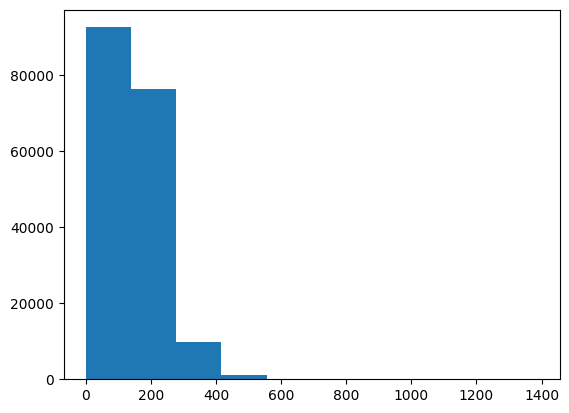

In [58]:
# Check distribution
plt.hist(char_lens, bins=10);

0-200 characters long

In [59]:
# 95% coverage
ouput_char_len = int(np.percentile(char_lens, 95))
ouput_char_len

290

In [60]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
# Create char-level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # Alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=ouput_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt vectorizer to training chars
char_vectorizer.adapt(train_chars)

In [62]:
# Check vocab characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of tokens in vocab: {len(char_vocab)}")
print(f"Most common tokens in vocab: {char_vocab[:10]}")
print(f"Least common tokens in vocab: {char_vocab[-10:]}")

Number of tokens in vocab: 28
Most common tokens in vocab: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
Least common tokens in vocab: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [64]:
# Test vectorizer
random_train_char = random.choice(train_chars)
print(f"Charified text:\n{random_train_char}")
print(f"\nLength of chars: {len(random_train_char.split())}")
print(f"\nVectorized chars:\n{char_vectorizer([random_train_char])}")
print(f"\nLength of vectorized chars: {len(char_vectorizer([random_train_char]).numpy()[0])}")

Charified text:
i n   t h e   @   a m e r i c a n   h e a r t   a s s o c i a t i o n   g u i d e l i n e s   ,   s u p r a g l o t t i c   d e v i c e s   (   s g d s   )   s u c h   a s   t h e   l a r y n g e a l   m a s k   a r e   p r o p o s e d   a s   a l t e r n a t i v e s   t o   t r a c h e a l   i n t u b a t i o n   f o r   c a r d i o p u l m o n a r y   r e s u s c i t a t i o n   .

Length of chars: 165

Vectorized chars:
[[ 4  6  3 13  2  5 15  2  8  4 11  5  6 13  2  5  8  3  5  9  9  7 11  4
   5  3  4  7  6 18 16  4 10  2 12  4  6  2  9  9 16 14  8  5 18 12  7  3
   3  4 11 10  2 21  4 11  2  9  9 18 10  9  9 16 11 13  5  9  3 13  2 12
   5  8 19  6 18  2  5 12 15  5  9 23  5  8  2 14  8  7 14  7  9  2 10  5
   9  5 12  3  2  8  6  5  3  4 21  2  9  3  7  3  8  5 11 13  2  5 12  4
   6  3 16 22  5  3  4  7  6 17  7  8 11  5  8 10  4  7 14 16 12 15  7  6
   5  8 19  8  2  9 16  9 11  4  3  5  3  4  7  6  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  

In [65]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

# Test char embedding layer
print(f"Charified text:\n{random_train_char}")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
i n   t h e   @   a m e r i c a n   h e a r t   a s s o c i a t i o n   g u i d e l i n e s   ,   s u p r a g l o t t i c   d e v i c e s   (   s g d s   )   s u c h   a s   t h e   l a r y n g e a l   m a s k   a r e   p r o p o s e d   a s   a l t e r n a t i v e s   t o   t r a c h e a l   i n t u b a t i o n   f o r   c a r d i o p u l m o n a r y   r e s u s c i t a t i o n   .
Embedded chars (after vectorization and embedding):
[[[-0.04871554 -0.03809208  0.01040866 ... -0.02597283  0.02738536
    0.03644444]
  [-0.00264024 -0.04086219 -0.03543477 ...  0.022353   -0.03231188
   -0.00790218]
  [-0.0240122   0.02863509 -0.0206247  ... -0.04232177  0.02124431
    0.01241386]
  ...
  [ 0.01949856  0.00316937 -0.04269385 ... -0.03443041 -0.02345291
   -0.04301654]
  [ 0.01949856  0.00316937 -0.04269385 ... -0.03443041 -0.02345291
   -0.04301654]
  [ 0.01949856  0.00316937 -0.04269385 ... -0.03443041 -0.02345291
   -0.04301654]]]
Character embedding shape: (1, 290, 25)


In [66]:
# Build the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 5

In [68]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
dev_char_dataset = tf.data.Dataset.from_tensor_slices((dev_chars, dev_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset, dev_char_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [78]:
# Fit the model
model_3_fit = model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=3,
            validation_data=dev_char_dataset,
            validation_steps=int(0.1 * len(dev_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 6ms/step - loss: 1.2258 - accuracy: 0.4927 - val_loss: 1.2167 - val_accuracy: 0.5030
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.2130 - accuracy: 0.5034 - val_loss: 1.1934 - val_accuracy: 0.5160
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 1.2015 - accuracy: 0.5056 - val_loss: 1.1851 - val_accuracy: 0.5146


In [79]:
# Evaluate on whole dev dataset
model_3.evaluate(dev_char_dataset)

  1/945 [..............................] - ETA: 9s - loss: 1.4488 - accuracy: 0.2188

945/945 [==============================] - 2s 2ms/step - loss: 1.1909 - accuracy: 0.5130


[1.1909029483795166, 0.5130411982536316]

In [80]:
model_3_pred_probs = model_3.predict(dev_char_dataset)
model_3_pred_probs

  1/945 [..............................] - ETA: 8s

945/945 [==============================] - 2s 2ms/step


array([[0.23789607, 0.28849313, 0.18406497, 0.24070644, 0.04883941],
       [0.10228519, 0.16856992, 0.15997045, 0.06256863, 0.50660586],
       [0.17096803, 0.166426  , 0.39961055, 0.219533  , 0.04346249],
       ...,
       [0.03052435, 0.07176085, 0.21129645, 0.02026799, 0.66615033],
       [0.05303581, 0.13431801, 0.3173405 , 0.08001684, 0.4152889 ],
       [0.1712566 , 0.20381908, 0.19937077, 0.06672017, 0.35883334]],
      dtype=float32)

In [81]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 4, 4], dtype=int64)>

In [82]:
model_3_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 51.30411756917781,
 'precision': 0.47960976944732236,
 'recall': 0.5130411756917781,
 'f1': 0.47421611793451157}

### Combining pretrained token embeddings and character embeddings

Time to start replicating the model in the paper.

In [89]:
# Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(300, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM layer
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Combine token and char embeddings into hybrid embeddings
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, # Combine token and char embeddings (concatenate token and char embeddings together)
                                                                  char_model.output])

# Create output layers - adding in dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct model with token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                          outputs=output_layer,
                          name="model_4_token_and_char_embeddings")

In [90]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

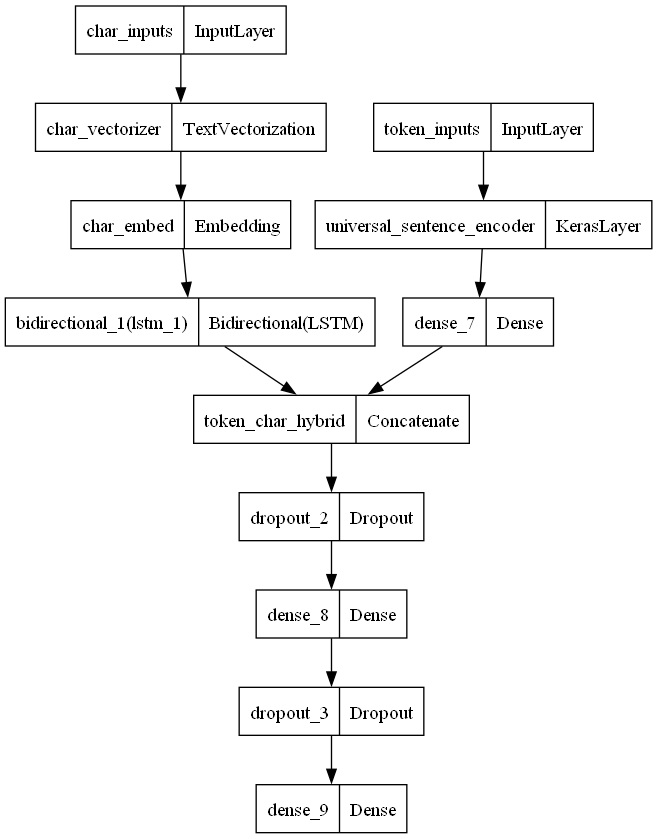

In [91]:
# Visualizing hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [92]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [93]:
# Combine char and token into a tf.data Dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat the above steps for the dev dataset
dev_char_token_data = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_chars))
dev_char_token_labels = tf.data.Dataset.from_tensor_slices((dev_labels_one_hot))
dev_char_token_dataset = tf.data.Dataset.zip((dev_char_token_data, dev_char_token_labels))
dev_char_token_dataset = dev_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# View training char and token embedding dataset
train_char_token_dataset, dev_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [95]:
# Fit the model
model_4_fit = model_4.fit(train_char_token_dataset,
                          steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                          epochs=3,
                          validation_data=dev_char_token_dataset,
                          validation_steps=int(0.1 * len(dev_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 47ms/step - loss: 0.9238 - accuracy: 0.6344 - val_loss: 0.7707 - val_accuracy: 0.7074
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7617 - accuracy: 0.7050 - val_loss: 0.6966 - val_accuracy: 0.7390
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7373 - accuracy: 0.7162 - val_loss: 0.6712 - val_accuracy: 0.7480


In [96]:
# Evaluate on whole dev dataset
model_4.evaluate(dev_char_token_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.6746 - accuracy: 0.7426


[0.6746213436126709, 0.7425857186317444]

In [97]:
# Make predictions
model_4_pred_probs = model_4.predict(dev_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[4.6795556e-01, 2.2008367e-01, 3.0103326e-03, 3.0468366e-01,
        4.2667976e-03],
       [4.0281337e-01, 3.2513916e-01, 1.7989294e-03, 2.6933619e-01,
        9.1231847e-04],
       [2.9260463e-01, 6.3707009e-02, 3.2395884e-02, 5.9277952e-01,
        1.8512893e-02],
       ...,
       [4.7457794e-04, 3.6454417e-03, 5.0176192e-02, 3.8617849e-04,
        9.4531763e-01],
       [1.0544212e-02, 6.7259446e-02, 3.0481613e-01, 5.8483751e-03,
        6.1153185e-01],
       [2.7149510e-01, 5.1590127e-01, 1.5930924e-01, 1.5430672e-02,
        3.7863746e-02]], dtype=float32)

In [98]:
# Convert pred probs to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [99]:
# Calculate results
model_4_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.25857275254866,
 'precision': 0.7435623375139868,
 'recall': 0.7425857275254866,
 'f1': 0.7402749366278352}

74% Accurate

### Transfer learning with pretrained token embeddings, character embeddings, and positional embeddings model

Using feature engineering may be valuable to extract higher accuracy. If we took our own knowledge about the data and encoded it into numerical format and gave it to our model for more information on our samples, we may be able to increase the accuracy of the model.

Using the line number and total lines from the data frames, we can utilize this information in determining the sequential order of the classification. More specifically, if we know Conclusion will never be the first sentence, we can feed that information to our model.

In [100]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Let's use positional embedding.

In [101]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

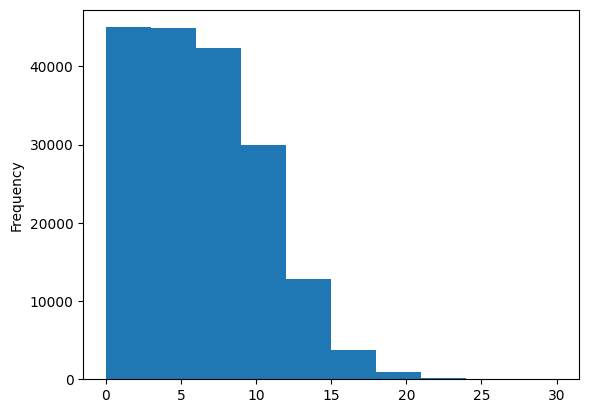

In [102]:
# Visualize distribution of line number
train_df.line_number.plot.hist();

In [113]:
# One hot encode line_number feature
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
dev_line_numbers_one_hot = tf.one_hot(dev_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Any sample with a line number value over 20 gets set to a tensor of all 0. Anything over 20 would significantly expand our tensor size and the vast majority of samples are not over 20.

In [114]:
# Check one-hot
train_line_numbers_one_hot[:20], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [115]:
# Checking different line numbers
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

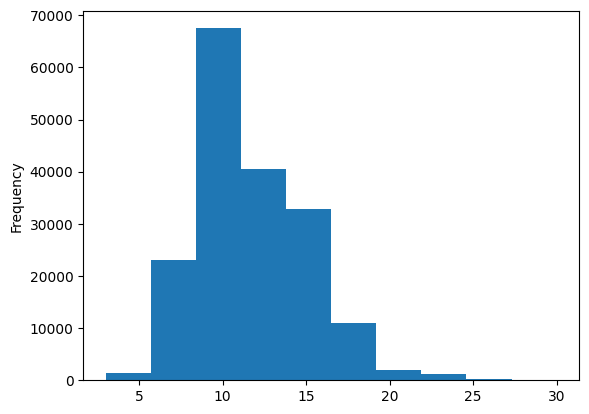

In [110]:
# Distribution
train_df.total_lines.plot.hist();

In [116]:
# Check coverage
np.percentile(train_df.total_lines, 98)

20.0

In [117]:
# One hot encode total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
dev_total_lines_one_hot = tf.one_hot(dev_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check one-hot
train_total_lines_one_hot[:20], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [118]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line number features
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Total lines features
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# Combine token and char embeddings into hybrid embeddings
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                               char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embeddings with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

# Create output layer
outputs = layers.Dense(num_classes, activation="softmax")(z)

# Combine token char positional embedding inputs with output layer into model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                          outputs=outputs,
                          name="model_5_token_char_positional_embedding")

In [119]:
model_5.summary()

Model: "model_5_token_char_positional_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  25

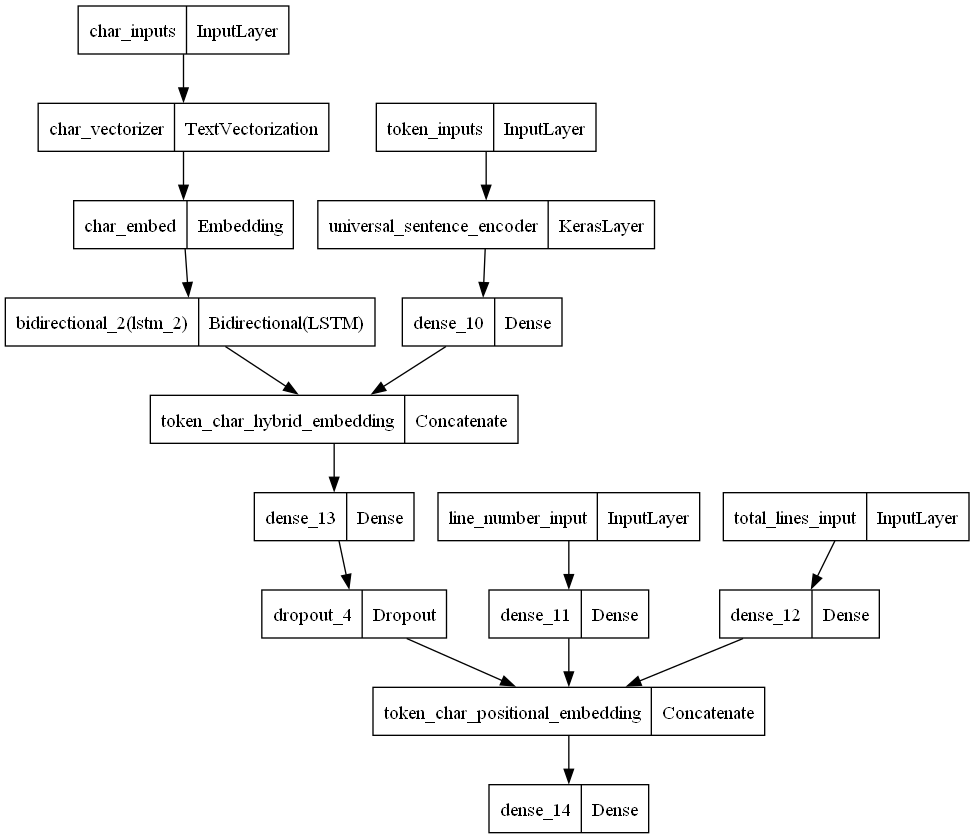

In [120]:
plot_model(model_5)

In [121]:
# Which layers are trainable
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x0000016C5E611AD0> True
<keras.src.engine.input_layer.InputLayer object at 0x0000016CEE147250> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x0000016C71FF9AD0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x0000016C45BD6D90> False
<keras.src.layers.core.embedding.Embedding object at 0x0000016CD488B150> True
<keras.src.layers.core.dense.Dense object at 0x0000016CD503D950> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x0000016CD4E7AC90> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x0000016CEDC16B50> True
<keras.src.engine.input_layer.InputLayer object at 0x0000016CD4DD8150> True
<keras.src.engine.input_layer.InputLayer object at 0x0000016CEF41DF90> True
<keras.src.layers.core.dense.Dense object at 0x0000016CEDBDAE50> True
<keras.src.layers.core.dense.Dense object at 0x0000016CD8361990> True
<keras.src.layers.core.dense.Dense object at 0x0000016CEF44

In [122]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to regularize model
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [123]:
# Create training and validation datasets
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create validation dataset
dev_pos_char_token_data = tf.data.Dataset.from_tensor_slices((dev_line_numbers_one_hot,
                                                              dev_total_lines_one_hot,
                                                              dev_sentences,
                                                              dev_chars))
dev_pos_char_token_labels = tf.data.Dataset.from_tensor_slices((dev_labels_one_hot))
dev_pos_char_token_dataset = tf.data.Dataset.zip((dev_pos_char_token_data, dev_pos_char_token_labels))
dev_pos_char_token_dataset = dev_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check datasets
train_pos_char_token_dataset, dev_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [124]:
# Fit the model
model_5_fit = model_5.fit(train_pos_char_token_dataset,
                          steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                          epochs=3,
                          validation_data=dev_pos_char_token_dataset,
                          validation_steps=int(0.1 * len(dev_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 43ms/step - loss: 1.0964 - accuracy: 0.7209 - val_loss: 0.9828 - val_accuracy: 0.8052
Epoch 2/3
562/562 [==============================] - 23s 42ms/step - loss: 0.9682 - accuracy: 0.8157 - val_loss: 0.9492 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 23s 42ms/step - loss: 0.9529 - accuracy: 0.8221 - val_loss: 0.9391 - val_accuracy: 0.8361


In [125]:
# Make predictions
model_5_pred_probs = model_5.predict(dev_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[0.51856357, 0.10447926, 0.01301984, 0.34469378, 0.01924349],
       [0.55934095, 0.09910925, 0.04203609, 0.2887379 , 0.01077582],
       [0.29182968, 0.11056691, 0.18477078, 0.3300356 , 0.08279707],
       ...,
       [0.03538724, 0.10514643, 0.04032508, 0.03618288, 0.7829583 ],
       [0.02788534, 0.30465326, 0.06963792, 0.02395464, 0.5738688 ],
       [0.22513528, 0.55532897, 0.11668781, 0.03879106, 0.06405696]],
      dtype=float32)

In [126]:
# Convert pred probs to classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [127]:
# Calculate results
model_5_results = calculate_results(y_true=dev_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.26823778631007,
 'precision': 0.8313759266394495,
 'recall': 0.8326823778631007,
 'f1': 0.8314526449524909}

83.1% Accurate

In [129]:
# Compare results
all_model_results = pd.DataFrame({"Baseline": baseline_results,
                                    "Conv1d": model_1_results,
                                    "Pretrained": model_2_results,
                                    "Char Conv1d": model_3_results,
                                    "Hybrid": model_4_results,
                                    "Tribrid": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Baseline,72.183238,0.718647,0.721832,0.698925
Conv1d,78.852774,0.785618,0.788528,0.786191
Pretrained,71.494770,0.715714,0.714948,0.711880
Char Conv1d,51.304118,0.479610,0.513041,0.474216
Hybrid,74.258573,0.743562,0.742586,0.740275
Tribrid,83.268238,0.831376,0.832682,0.831453


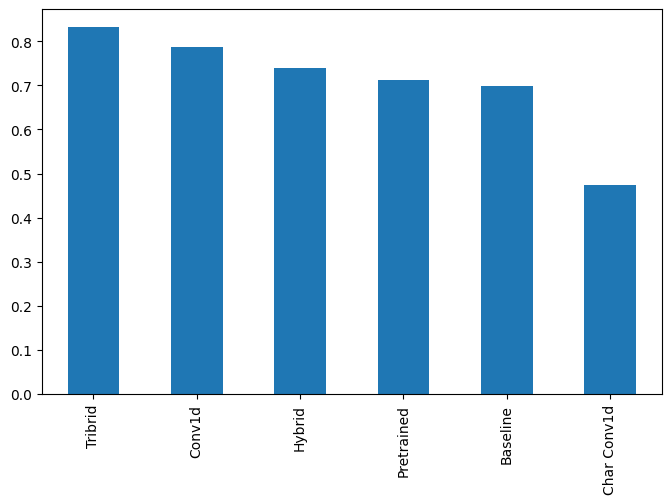

In [132]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(8, 5));

In [133]:
# Save best model
model_5.save("token_char_pos_model")

INFO:tensorflow:Assets written to: token_char_pos_model\assets


INFO:tensorflow:Assets written to: token_char_pos_model\assets
